## Es 05
<b>Use the Metropolis algorithm to sample $|\Psi_{1,0,0}(x,y,z)|^2$ and $|\Psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$. Use the sampled positions to estimate $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$. As usual, use data blocking and give an estimate of the statistical uncertainties.
<span style="color:red">Show a picture of your estimations of $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</font>.</b>

- <b> Use Bohr radius units, $a_0$ for distances
- <b> Choose the step of the uniform transition probability $T(\vec{x}|\vec{y})$ in order to obtain 50% of acceptance in both cases
- <b> Choose a reasonable starting point in the 3D space and equilibrate your sampling before to start measuring the radius. What do you observe when you start very far from the origin?
- <b> How large should be the number of Monte Carlo Metropolis steps in each block?
- <b> <span style="color:red">If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\Psi_{2,1,0}}$ are equivalent?</span>

### Implementation of the Metropolis algorithm
My first step was to write a function that would implement the Metropolis algorithm in order to sample the wavefunction amplitudes.I made use of the class *RandomWalk* that I had built for exercise 3, that includes as private elements a random generator and the random walk position, and has methods to progressively get the random walk position and distance from the origin(norm of the position vector). I added a step function that increments each of the components by a randomly determined fraction of the input step length, so that I am actively generating a step in a random direction with a length between 0 and step_length. Then in the main file I created a *Metropolis_step()* function, that uses this method to increment the RW, and then generates a new random number, checks if it lower than the Metropolis acceptance, and if not reverts the RW to its old position:

**RandomWalk.cpp:**
```c++
void RandomWalk::Step_unif (){

for (int i=0;i<3;i++){
	double step = _steplength*_rnd.Rannyu(-1.,1.);
 	_position[i] += step;
}
}
```
**main.cpp:**
``` c++
double Metropolis_Acceptance(double p_new,double p_old,double T_fwd, double T_bkw){ //y:old move, x:new move
	double q = (T_fwd*p_new)/(T_bkw* p_old);
	if (q>=1.) return 1.;
	else return q;
}


void Metropolis_Step(Random &rnd,RandomWalk &RW, double &acc_rate){

		vec old_pos = RW.Get_position();
		double r_old = RW.GetDistance();

		RW.Step_unif();
		double r_new = RW.GetDistance();
		
		double a_0=1;

		double p_old = H_1s(a_0,r_old);
		double p_new = H_1s(a_0,r_new);
		double T_bkw=1.;
		double T_fwd =1.;

		double A=Metropolis_Acceptance(p_new,p_old,T_fwd,T_bkw);

		double x=rnd.Rannyu();

		if(x>A) {
			RW.SetPosition(old_pos);
		}

		else acc_rate ++;
}

To check if the algorithm is working, we can visualize the distribution points for only one random walk with 5000 steps, first starting from  $\vec{r}=(0,0,0)$:

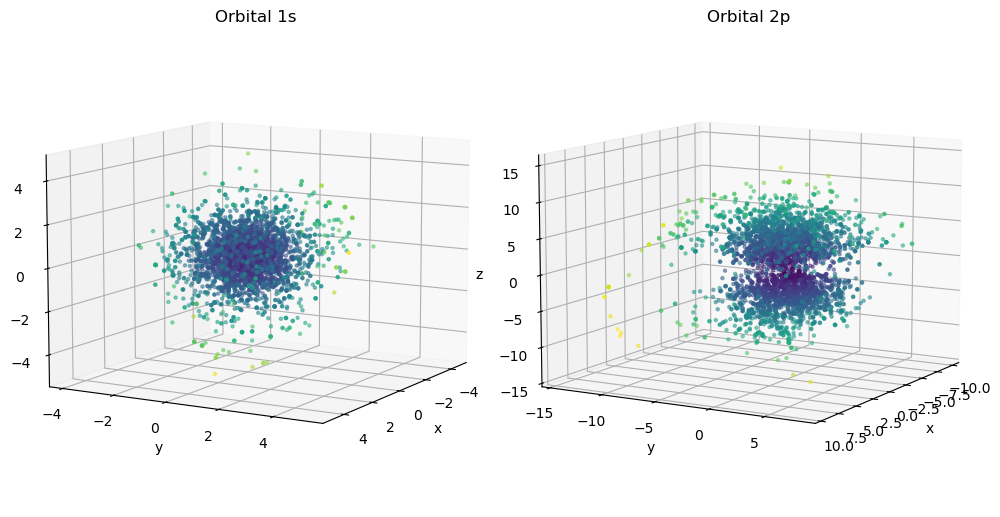

In [66]:
import pandas as pd
file = "1s.csv"
df=pd.read_csv(file, sep='\t')
filep = '2p.csv'
dfp = pd.read_csv(filep,sep='\t')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 6))
files = [df,dfp]
for i,data in enumerate(files):
    axes[i].scatter(
    data['x'], data['y'], data['z'],
    c=data['r'], alpha=0.5, marker='.'
)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].view_init(10,30)

axes[0].set_title('Orbital 1s')
axes[1].set_title('Orbital 2p')
plt.tight_layout()

To estimate how long it takes to equilibrate, I execute 2000steps starting from a far away position: ($\vec{r}=(50,50,50)$)

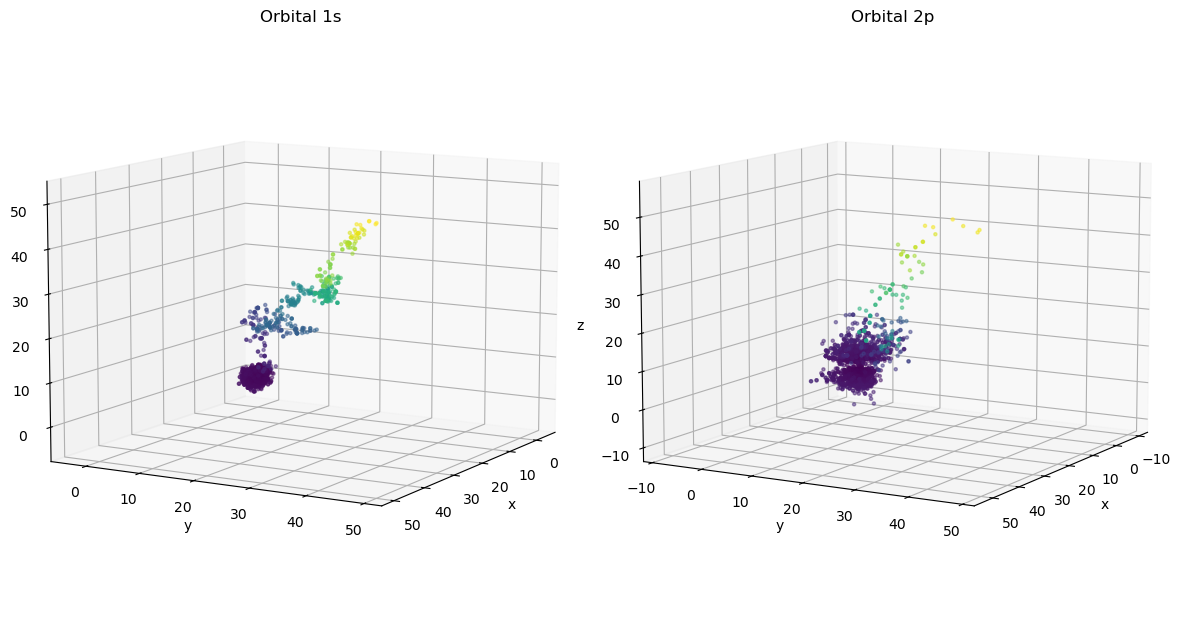

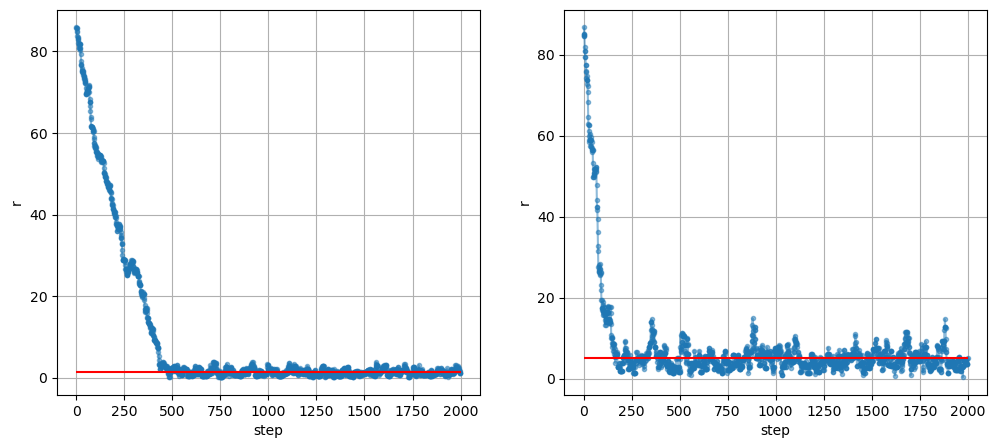

In [49]:
import pandas as pd
file = "1s.csv"
df=pd.read_csv(file, sep='\t')
filep = '2p.csv'
dfp = pd.read_csv(filep,sep='\t')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 8))
files = [df,dfp]
for i,data in enumerate(files):
    axes[i].scatter(
    data['x'], data['y'], data['z'],
    c=data['r'], alpha=0.5, marker='.'
)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].view_init(10,30)

axes[0].set_title('Orbital 1s')
axes[1].set_title('Orbital 2p')
plt.tight_layout()

fig,axr = plt.subplots(1,2,figsize =(12,5))
for i,data in enumerate(files):
    axr[i].plot(data.index, data['r'],alpha=0.5, marker='.')
    axr[i].set_xlabel('step')
    axr[i].set_ylabel('r')
    axr[i].grid()

axr[0].hlines(1.5,0,2000,color='red')
axr[1].hlines(5.,0,2000,color='red')

plt.show() 

We can see that even when starting from a far away position after some initial equilibration steps (they are more for the 1s because its radius is smaller), theradius adjust around the expected one and the point distribution reproduces the orbitals.

### Determining optimal step length
Since the step length is directly connected to the acceptance rate of the Metropolis algorithm, I first tried to run only one block with for various values of the step length to determine which one would give me an acceptance of 50%.

Text(0.5, 1.0, 'Acceptance rate for 2p orbital')

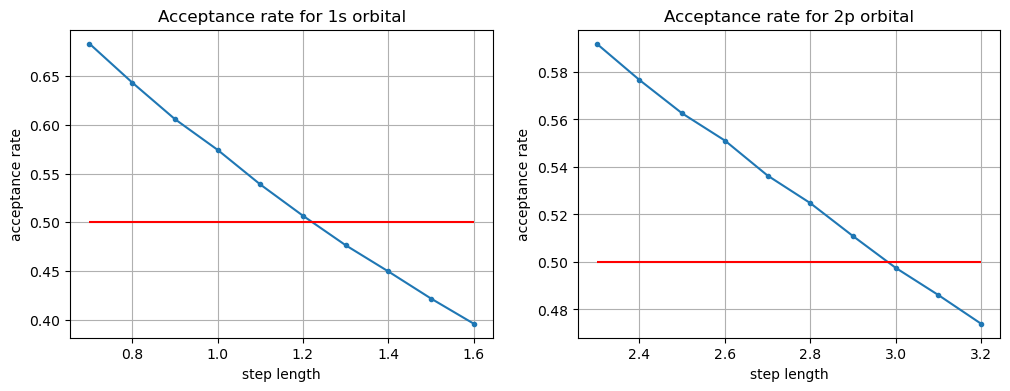

In [19]:
import pandas as pd
df_acc = pd.read_csv("acceptance1s.csv",sep='\t')
df_accp = pd.read_csv('acceptance2p.csv',sep ='\t')

import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(12,4))
files = [df_acc,df_accp]
for i,data in enumerate(files):
    axes[i].plot(data['step_length'],data['acceptance'], marker = '.')
    axes[i].hlines(0.5,data['step_length'][0],data['step_length'][9],color ='red')
    axes[i].grid()
    axes[i].set_xlabel('step length')
    axes[i].set_ylabel('acceptance rate')

axes[0].set_title('Acceptance rate for 1s orbital')
axes[1].set_title('Acceptance rate for 2p orbital')


In [24]:
print(f'1s acceptance rate with step length 1.2: {df_acc['acceptance'][df_acc['step_length']==1.2].values}')
print(f'2p acceptance rate with step length 2.9: {df_accp['acceptance'][df_accp['step_length']==2.9].values}')

1s acceptance rate with step length 1.2: [0.5068]
2p acceptance rate with step length 2.9: [0.51089]


### Estimate average radius
To determined th expectation value for the radius using the block average method, running 100 blocks with $10^6$ steps each

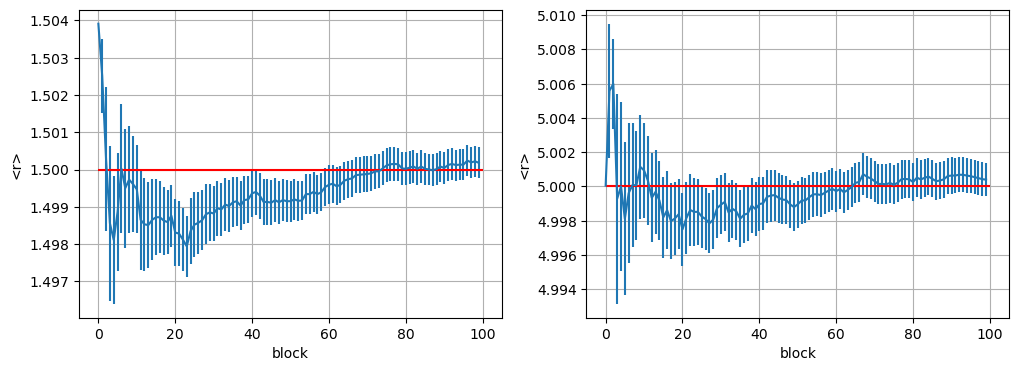

In [68]:
dfr1=pd.read_csv("r_ave1s.csv", sep='\t')
dfr2=pd.read_csv("r_ave2p.csv", sep='\t')

fig,axes = plt.subplots(1,2,figsize=(12,4))
files = [dfr1,dfr2]
for i,data in enumerate(files):
    axes[i].errorbar(data['block'],data['prog_ave'],yerr = data['err'])
    axes[i].set_xlabel('block')
    axes[i].set_ylabel('<r>')
    axes[i].grid()

axes[0].hlines(1.5,0,100,color='red')
axes[1].hlines(5,0,100,color='red')


### Gaussian transition probability
I added another type of step to the Randomwalk  class that generates a new position with a gaussian probability with width = step length.
```c++
void RandomWalk::Step_gauss (){

for (int i=0;i<3;i++){
	double step = _rnd.Gauss(0.,_steplength);
 	_position[i] += step;
}
}

An initial view with 2000 steps, starting from $\vec{r}=(50,50,50)$

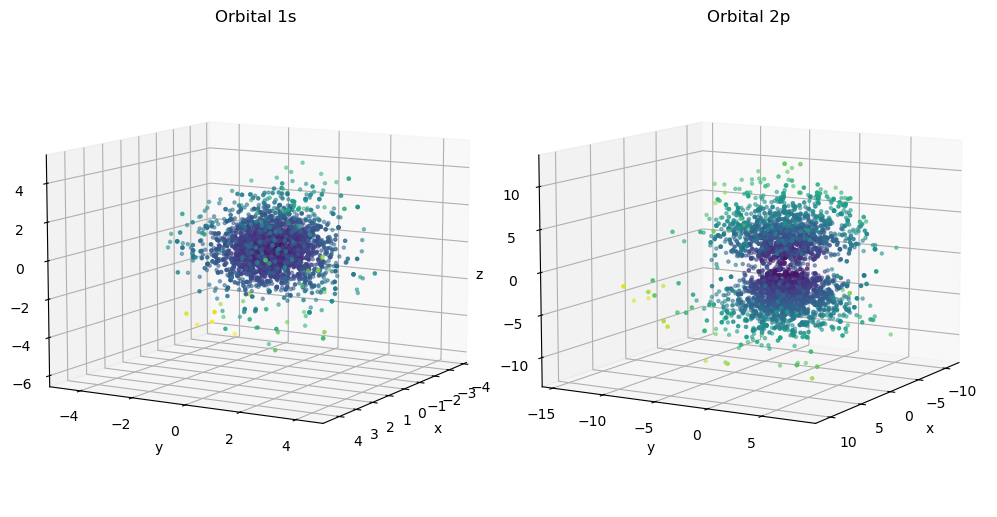

In [64]:
import pandas as pd
file = "1s.csv"
df=pd.read_csv(file, sep='\t')
filep = '2p.csv'
dfp = pd.read_csv(filep,sep='\t')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10, 6))
files = [df,dfp]
for i,data in enumerate(files):
    axes[i].scatter(
    data['x'], data['y'], data['z'],
    c=data['r'], alpha=0.5, marker='.'
)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].view_init(10,30)

axes[0].set_title('Orbital 1s')
axes[1].set_title('Orbital 2p')
plt.tight_layout()
plt.show()

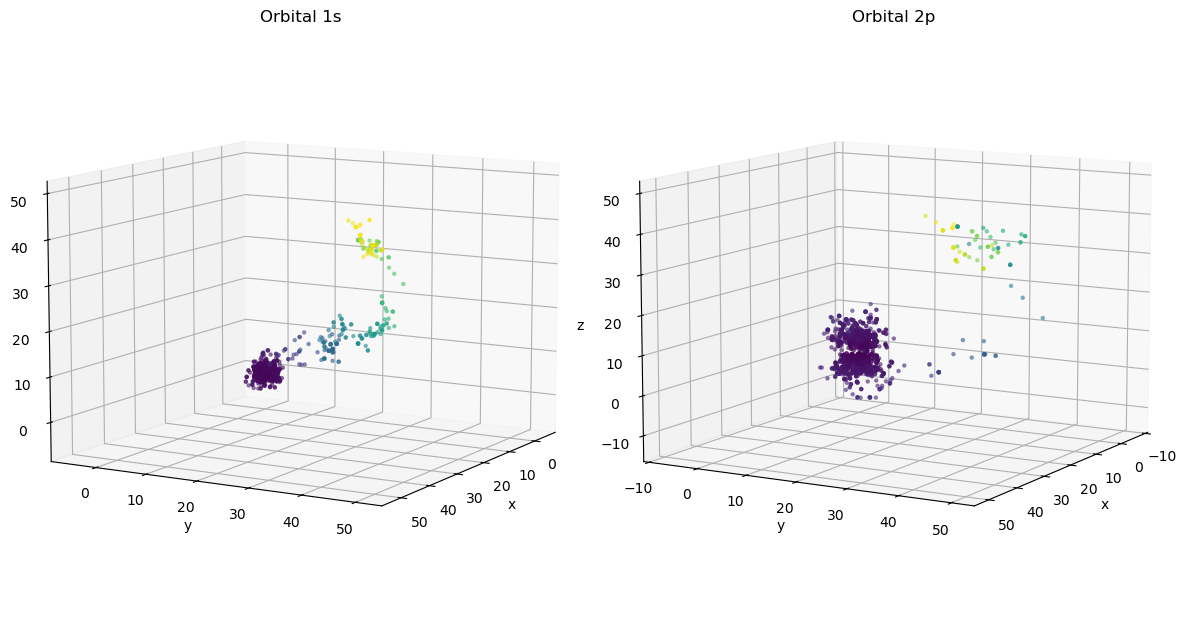

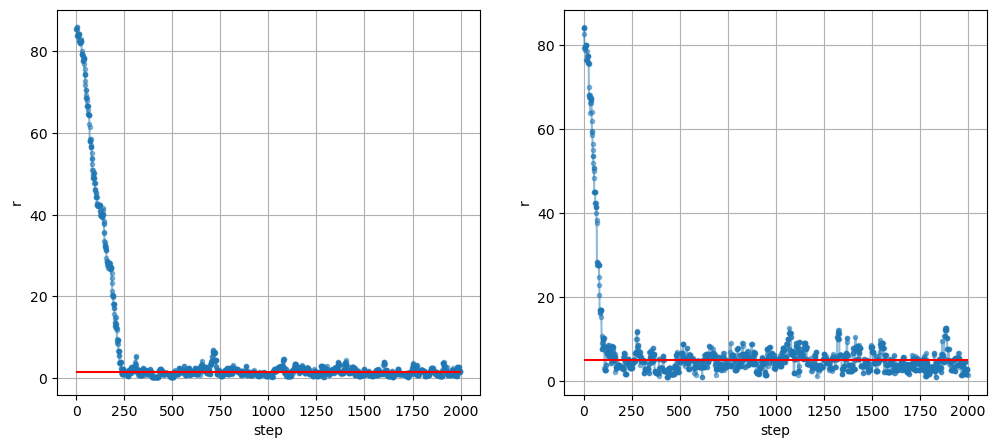

In [52]:
import pandas as pd
file = "1s.csv"
df=pd.read_csv(file, sep='\t')
filep = '2p.csv'
dfp = pd.read_csv(filep,sep='\t')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 8))
files = [df,dfp]
for i,data in enumerate(files):
    axes[i].scatter(
    data['x'], data['y'], data['z'],
    c=data['r'], alpha=0.5, marker='.'
)
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_zlabel('z')
    axes[i].view_init(10,30)

axes[0].set_title('Orbital 1s')
axes[1].set_title('Orbital 2p')
plt.tight_layout()

fig,axr = plt.subplots(1,2,figsize =(12,5))
for i,data in enumerate(files):
    axr[i].plot(data.index, data['r'],alpha=0.5, marker='.')
    axr[i].set_xlabel('step')
    axr[i].set_ylabel('r')
    axr[i].grid()

axr[0].hlines(1.5,0,2000,color='red')
axr[1].hlines(5.,0,2000,color='red')

plt.show() 

Text(0.5, 1.0, 'Acceptance rate for 2p orbital')

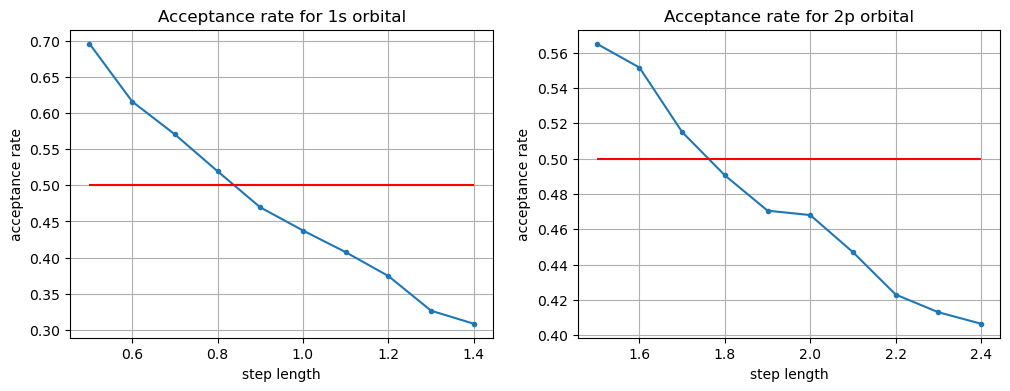

In [54]:
import pandas as pd
df_acc = pd.read_csv("acceptance1s.csv",sep='\t')
df_accp = pd.read_csv('acceptance2p.csv',sep ='\t')

import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,2,figsize=(12,4))
files = [df_acc,df_accp]
for i,data in enumerate(files):
    axes[i].plot(data['step_length'],data['acceptance'], marker = '.')
    axes[i].hlines(0.5,data['step_length'][0],data['step_length'][9],color ='red')
    axes[i].grid()
    axes[i].set_xlabel('step length')
    axes[i].set_ylabel('acceptance rate')

axes[0].set_title('Acceptance rate for 1s orbital')
axes[1].set_title('Acceptance rate for 2p orbital')

In [67]:
print(f'1s acceptance rate with step length 0.8: {df_acc['acceptance'][df_acc['step_length']==0.8].values}')
print(f'2p acceptance rate with step length 1.8: {df_accp['acceptance'][df_accp['step_length']==1.8].values}')

1s acceptance rate with step length 0.8: [0.5195]
2p acceptance rate with step length 1.8: [0.4905]


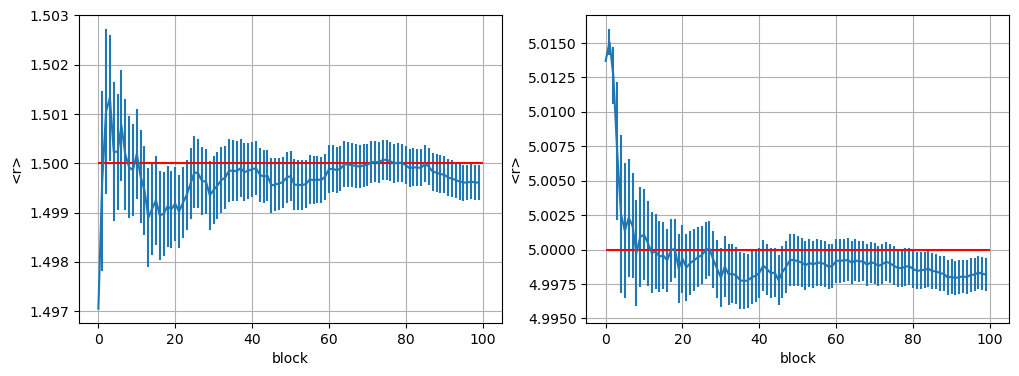

In [59]:
dfr1=pd.read_csv("r_ave1s.csv", sep='\t')
dfr2=pd.read_csv("r_ave2p.csv", sep='\t')

fig,axes = plt.subplots(1,2,figsize=(12,4))
files = [dfr1,dfr2]
for i,data in enumerate(files):
    axes[i].errorbar(data['block'],data['prog_ave'],yerr = data['err'])
    axes[i].set_xlabel('block')
    axes[i].set_ylabel('<r>')
    axes[i].grid()

axes[0].hlines(1.5,0,100,color='red')
axes[1].hlines(5,0,100,color='red')
